In [1]:
%matplotlib inline
import sys
import os

import matplotlib.pyplot as plt
sys.path.append("../")
from dataset import Dataset

import tensorflow as tf

## Graph Visualization

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


## Load DataSet

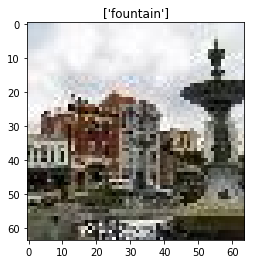

In [4]:
trainset = Dataset('train')

num_classes = trainset.num_classes
num_data = trainset.num_data

images, labels = trainset[:2]

for image, label in zip(images,labels):
    plt.title(trainset.label2name(label))
    plt.imshow(image)
    plt.show()

## Building Model

In [6]:
num_classes = 200

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,(None,64,64,3),name='X')
    labels = tf.placeholder(tf.int32,(None),name='labels')
    
    is_train = tf.placeholder_with_default(False,(),name='is_train')    
    lr = tf.placeholder_with_default(0.0001,(),name='learning_rate')
    
    he_init = tf.initializers.he_normal()
    with tf.variable_scope('VGG_Block1'):
        conv = tf.layers.Conv2D(16,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(x)
        conv = tf.layers.Conv2D(16,(3,3),padding='SAME',
                                kernel_initializer=he_init,                                
                                 activation=tf.nn.relu)(conv)
        pool = tf.layers.MaxPooling2D((2,2),(2,2))(conv)
    
    with tf.variable_scope('VGG_Block2'):
        conv = tf.layers.Conv2D(32,(3,3),padding='SAME',
                                kernel_initializer=he_init,                                
                                 activation=tf.nn.relu)(pool)
        conv = tf.layers.Conv2D(32,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(conv)
        pool = tf.layers.MaxPooling2D((2,2),(2,2))(conv)

    with tf.variable_scope('VGG_Block3'):
        conv = tf.layers.Conv2D(64,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(pool)
        conv = tf.layers.Conv2D(64,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(conv)
        pool = tf.layers.MaxPooling2D((2,2),(2,2))(conv)
    
    with tf.variable_scope('VGG_Block4'):
        conv = tf.layers.Conv2D(128,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(pool)
        conv = tf.layers.Conv2D(128,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(conv)
        pool = tf.layers.MaxPooling2D((2,2),(2,2))(conv)

    with tf.variable_scope('VGG_Block5'):
        conv = tf.layers.Conv2D(128,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(pool)
        conv = tf.layers.Conv2D(128,(3,3),padding='SAME',
                                kernel_initializer=he_init,
                                 activation=tf.nn.relu)(conv)
        pool = tf.layers.MaxPooling2D((2,2),(2,2))(conv)        

    with tf.variable_scope('VGG_FC'):
        pool = tf.layers.Flatten()(pool)
        fc = tf.layers.Dense(1028,activation=tf.nn.relu,
                             kernel_initializer=he_init)(pool)
        fc = tf.layers.Dense(1028,activation=tf.nn.relu,
                             kernel_initializer=he_init)(fc)
        
    with tf.variable_scope('OUTPUT'):
        logits = tf.layers.Dense(num_classes)(fc)
    
    logits = tf.identity(logits,name='logits')
    y_pred = tf.nn.softmax(logits,name='prediction')

    loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)    
    
    with tf.variable_scope('metrics'):
        top_5 = tf.reduce_mean(
            tf.cast(tf.nn.in_top_k(logits,labels,k=5),tf.float32))
        top_1 = tf.reduce_mean(
            tf.cast(tf.nn.in_top_k(logits,labels,k=1),tf.float32))
        
    top_5 = tf.identity(top_5,name='top_5_accuracy')
    top_1 = tf.identity(top_1,name='top_1_accuracy')
        
    
show_graph(graph)